In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import os
import time
from tqdm import tqdm
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.calibration import calibration_curve,CalibratedClassifierCV
import seaborn as sns
import pandas as pd, numpy as np
import random
from sklearn.metrics import confusion_matrix, average_precision_score
import matplotlib.pyplot as plt 
%matplotlib inline
import re
import scipy.stats as st
from mord import LogisticIT, LogisticAT
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from pprint import pprint
from sklearn import datasets, linear_model
from sklearn.metrics import confusion_matrix,f1_score,plot_confusion_matrix, classification_report, plot_roc_curve,accuracy_score, f1_score,roc_curve, roc_auc_score,mean_squared_error, mean_absolute_error,r2_score,precision_recall_curve
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression,Ridge,RidgeCV,LassoCV
from sklearn.model_selection import GridSearchCV, KFold,RepeatedKFold,train_test_split,RandomizedSearchCV,ParameterGrid
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import heapq

In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mpl

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [5]:
def clean_and_featurize(df):
    """Something is happening here to clean the data...."""
    labeled = df
    #labeled = labeled[['Report_ID','Report_Text','MLS_mm']]
    
    #rename columns to relevant
    labeled = labeled.rename(columns={"Report_ID": "Report_Number"})
    
    # Keep only those with IMPRESSIONS
    labeled = labeled.iloc[[x for x in range(labeled.shape[0]) if 'IMPRESSION:' in labeled.Report_Text.iloc[x]]]
    
    # replace whitespace with space ***************************
    labeled['Report_Text_clean'] = labeled['Report_Text'].apply(lambda text: ' '.join(text.split()))
    
    #REMOVE HEADER:
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('-'*78, text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('HISTORY:', text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('REPORT ', text, 1)[-1])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: re.split('REPORT:', text, 1)[-1])
    
    #REMOVE FOOTER:
    # Remove footer parts
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('electronically signed by:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       ''.join(re.split('i, the teaching physician, have reviewed the images and agree with the report as written', text, flags=re.IGNORECASE)))
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('radiologists: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('providers: signatures:', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('findings were discussed on', text, flags=re.IGNORECASE)[0])
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: 
                                                       re.split('this report was electronically signed by', text, flags=re.IGNORECASE)[0])

    # Remove reference texts =====
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: ''.join([x for i,x in enumerate(text.split('='*34)) if i != 1]))
    
    labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: text.lower())
    
    
    # Replace ngrams in Report_Text & IMPRESSION with their units
    for group in wordgroups:
        labeled['Report_Text_clean'] = labeled.Report_Text_clean.apply(lambda text: text.replace(group, ''.join(group.split())))

    labeled = labeled.drop_duplicates(subset=['Report_Number'])
    labeled = labeled.reset_index(drop=True)
    
    return labeled


def create_BOW_matrix(df,vectorizer='count',doc_col_name="Report_Text_clean"):
    """Takes a DataFrame in which there is a column of documents, then parses through those
    texts in order to create a matrix in which the entries are the token counts per document.
    Returns this matrix as a DataFrame"""
    #initialize vectorizer
    if vectorizer=='count':
        vectorizer = CountVectorizer(min_df=2) #ignore if term appears in <cutoff % of documents
    else:
        vectorizer=TfidfVectorizer(min_df=2)
    #Obtain counts using the column name corresponding to the radiology reports
    features = vectorizer.fit_transform(df[doc_col_name]).todense() 
    vocab_counts = vectorizer.vocabulary_
    feature_names = vectorizer.get_feature_names()
    #Each one of the elements of the table 
    X_all = pd.DataFrame(features, columns = feature_names)
    
    return X_all

In [4]:
def classifier_complete(n_trials,cleaned_results_df,BOW_matrix,doc_col_name,classifier,print_complete=True):
    """A comprehensive function that takes in all data and a classifier of choice then computes 
    epidemiologic statistics for that classifier as well as returns numpy arrays corresponding to 
    ROC, PR, and calibration curves. Hyperparameter tuning is included within classifier definitions, which
    occur within the body of the function as below"""
    
    num_trials = n_trials
    score = 'roc_auc' #metric by which to evaluate
    
    ###########GRAPHS###########################
    
    #ROC
    fprs = []
    tprs = []
    
    #PR
    
    precisions_4graph = [] #this vector is distinct from the epdemiologic measures of "precision"
    recalls = []
    
    #Calibration curves
    mpvs = []
    fops = []
    
    
    #########STATS##############################
    #statistics
    accuracies=[]
    aucs=[]
    auprs=[]
    specificities=[]
    sensitivities=[]
    precisions=[]
    f1s=[]
    times=[]
    
    
    #STATS
    accuracy=0
    auc = 0 #will keep track of average AUC at the end of this all
    aupr=0
    specificity=0
    sensitivity=0
    precision=0
    f1=0
    
    sm = SMOTE(random_state=42)
    
    for trial in range(1,num_trials+1):
        t0=time.time()
        print('Results for trial ',trial)
        X_train,X_test,y_train,y_test = train_test_split(BOW_matrix,cleaned_results_df[str(doc_col_name)],test_size=0.20)
        #print(type(X_train))
        #print(type(y_train))
        X_res, y_res = sm.fit_resample(X_train, y_train)
        
        if classifier=='logreg':
        
            tuned_parameters =[{'tol': np.arange(0.0001, 0.1 + 0.01, 0.01)}]

            #initialize Logistic Regression with GridSearch over 'tolerance' parameter
            outcome_presence = GridSearchCV(LogisticRegression(penalty = 'l1',max_iter=1000, random_state=100, solver='liblinear'), 
                                        tuned_parameters, cv = 10, scoring = 'roc_auc')
            
                    #Calibrate the classifier with Platt scaling
            outcome_presence=CalibratedClassifierCV(outcome_presence)
            
            
        elif classifier=='rf':
            
            maxTrees = 200
            maxDepth = 10
            minBucket = 10
            
            tuned_parameters = [{'n_estimators': range(10,maxTrees+10,100),'max_depth':range(3,maxDepth+1), 'min_samples_leaf':range(1,minBucket+1), 'bootstrap' : [True, False]}]
        
            outcome_presence = RandomizedSearchCV(RandomForestClassifier(criterion="gini", random_state=100),
                               tuned_parameters, cv=10, scoring = score) 
            
            outcome_presence=CalibratedClassifierCV(outcome_presence)
            
        elif classifier=='nn':
            mlp_parameters = [{'hidden_layer_sizes': [50,100,200]}]
        
        #initialize Logistic Regression with GridSearch over 'tolerance' parameter
            outcome_presence = GridSearchCV(MLPClassifier(learning_rate_init=0.003), 
                                        mlp_parameters, cv = 5, scoring = 'roc_auc')
            
        elif classifier=='CART':
            maxDepth = 10
            minBucket = 10
            tuned_parameters = [{'max_depth':range(3,maxDepth+1), 'min_samples_leaf':range(1,minBucket+1)}]
            outcome_presence = GridSearchCV(tree.DecisionTreeClassifier(criterion="gini", random_state=100, splitter = 'best'),
                               tuned_parameters, cv=10, scoring = score)
        
            #Calibrate the classifier with Platt scaling
            outcome_presence=CalibratedClassifierCV(outcome_presence)
            
        elif classifier=='svm':
            tuned_parameters = {'C': [0.1,], 
                          'gamma': [0.1, 0.01, 0.001]} 
            outcome_presence=GridSearchCV(SVC(),tuned_parameters,cv=5,scoring=score)
            outcome_presence=CalibratedClassifierCV(outcome_presence)
            
        elif classifier=='knn':
            max_neighbors=7
            tuned_parameters=[{'n_neighbors':range(2,max_neighbors)}]
            outcome_presence = GridSearchCV(KNeighborsClassifier(),
                   tuned_parameters, cv=10, scoring = score)
            outcome_presence=CalibratedClassifierCV(outcome_presence)
            
        
        #SMOTE resampling
        outcome_presence.fit(X_res,y_res)
        
        #outcome_presence.fit(X_train, y_train)
        
        #categorical predictions
        y_pred = outcome_presence.predict(X_test)
        #raw probabilities
        y_proba = outcome_presence.predict_proba(X_test)[:,1]
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        if print_complete:
            print(f'TP: {tp} \n')
            print(f'TN: {tn} \n')
            print(f'FP: {fp} \n')
            print(f'FN: {fn} \n')
            print(3*'\n')
        #for optional plotting:
        fpr,tpr,_ = roc_curve(y_test,y_proba) #ROC
        pr_4graph,recall,_ = precision_recall_curve(y_test,y_proba) #PR
        fop, mpv = calibration_curve(y_test, y_proba, n_bins=10) #calibration
        
        #runtime calculation
        t1=time.time()
        total_time=t1-t0
        times.append(total_time)

        
        #ROC Curve
        fprs.append(fpr)
        tprs.append(tpr)
        
        #PR Curve
        precisions_4graph.append(pr_4graph)
        recalls.append(recall)
        
        #Calibration Curve
        mpvs.append(mpv)
        fops.append(fop)
        
        
        
        #print(roc_auc_score(y_test,y_proba))
        
        #for specific trial
        trial_auc=roc_auc_score(y_test, y_proba)
        trial_aupr=average_precision_score(y_test,y_proba)
        trial_sensitivity=tp/(tp+fn)
        trial_specificity=tn/(tn+fp)
        trial_precision=tp/(tp+fp)
        trial_f1=f1_score(y_test,y_pred)
        trial_accuracy=(tp+tn)/(tp+tn+fp+fn)
        
        #for averaging over all trials
        auc += trial_auc #update running sum of AUC scores
        aupr+=trial_aupr
        sensitivity+=trial_sensitivity
        specificity+=trial_specificity
        precision+=trial_precision
        f1+=trial_f1
        accuracy+=trial_accuracy
        
        #for standard dev over all trials 
        aucs.append(trial_auc)
        auprs.append(trial_aupr)
        sensitivities.append(trial_sensitivity)
        specificities.append(trial_specificity)
        precisions.append(trial_precision)
        f1s.append(trial_f1)
        accuracies.append(trial_accuracy)
        
        
        
    #average values 
    average_AUC = auc/n_trials
    average_AUPR=aupr/n_trials
    average_sensitivity=sensitivity/n_trials
    average_specificity=specificity/n_trials
    average_precision=precision/n_trials
    average_f1=f1/n_trials
    average_accuracy=accuracy/n_trials
    
    
    
    #standard deviations
#     std_auc=np.round(np.std(aucs),3)
#     std_sens=np.round(np.std(sensitivities),3)
#     std_spec=np.round(np.std(specificities),3)
#     std_prec=np.round(np.std(precisions),3)
#     std_f1=np.round(np.std(f1s),3)
#     std_acc=np.round(np.std(accuracies),3)
    
    #95th %ile Confidence Intervals:
    ci95_auc=mean_confidence_interval(aucs)
    ci95_aupr=mean_confidence_interval(auprs)
    ci95_sens=mean_confidence_interval(sensitivities)
    ci95_spec=mean_confidence_interval(specificities)
    ci95_prec=mean_confidence_interval(precisions)
    ci95_acc=mean_confidence_interval(accuracies)
    
    
    
#     ci95_auc=st.t.interval(alpha=0.95, df=len(aucs)-1, loc=np.mean(aucs), scale=st.sem(aucs))
#     ci95_sens=st.t.interval(alpha=0.95, df=len(sensitivities)-1, loc=np.mean(sensitivities), scale=st.sem(sensitivities))
#     ci95_spec=st.t.interval(alpha=0.95, df=len(specificities)-1, loc=np.mean(specificities), scale=st.sem(specificities))
#     ci95_prec=st.t.interval(alpha=0.95, df=len(precisions)-1, loc=np.mean(precisions), scale=st.sem(precisions))
#     ci95_f1=st.t.interval(alpha=0.95, df=len(f1s)-1, loc=np.mean(f1s), scale=st.sem(f1s))
#     ci95_acc=st.t.interval(alpha=0.95, df=len(accuracies)-1, loc=np.mean(accuracies), scale=st.sem(accuracies))
    
    
    
    print('Average runtime:',mean_confidence_interval(times))
    print(f'{classifier} for {doc_col_name}.\n ======================================\n')
    
    print(f'AUC [{ci95_auc}]. AUPR [{ci95_aupr}]. Sensitivity [{ci95_sens}]. Specificity[{ci95_spec}]\n')
    print(f'Precision [{ci95_prec}]. Accuracy [{ci95_acc}]')
    

    ###RETURN THE ARRAYS FOR THE GRAPHS
    return fprs,tprs,precisions_4graph,recalls,mpvs,fops

## Prep Data

In [9]:
df = pd.read_csv('6.1.21 deidComplete REDCap Reports Non-duplicate Version 3.csv')
df.rename(columns={'report_text': 'Report_Text', 'mls_mm_v2': 'MLS_mm','record_id':'Report_ID','ecass_v2':'ECASS','edema_severity_report':'edema_severity'}, inplace=True)
wordgroups = list(pd.read_excel('wordgroups.xlsx')['Word Groupings'])#now clean and featurize


df=df.dropna(subset=['ivh_v2'])
df['ivh_present']=df['ivh_v2'].apply(lambda x: 0 if x==1.0 else 1)
df['ECASS']=df['ECASS'].fillna(0)
df['severe_ecass']=df['ECASS'].apply(lambda x: 0 if x<3.0 else 1)
df['MLS_mm']=df['MLS_mm'].fillna(0)
df['MLS_presence']=df['MLS_mm'].apply(lambda x: 0 if x==0 else 1)
#df_edema = df[np.logical_or(df['MLS_presence']==0,df['MLS_presence']==1)]
df['edema_report']=df['edema_report'].fillna(0)
df['edema_report']=df['edema_report'].apply(lambda x: int(x))

# #RunItBack


In [10]:
np.random.seed(66)



for classifier in ['knn']:#'knn','rf','nn']:
#for classifier in ['logreg']:
    #for outcome in ['ivh_present','hem_conv_v2','severe_ecass']:

    for outcome in ['ivh_present']: #hem_conv_v2','severe_ecass','ivh_present']:
    #for outcome in ['severe_ecass']:
    
        for vectorizer in ['count']:

            print(f'Now testing {classifier} with {outcome} and {vectorizer} vectorizer')

            if outcome=='severe_ecass':
                df_edema=df[df['hem_conv_v2']==1] #only look at ecass for those with hemorrhagic conversion =1
                
                df_edema=df[np.logical_or(df[outcome]==0,df[outcome]==1)]


                labeled = clean_and_featurize(df_edema)


                df_edema=df_edema.loc[df_edema.Report_ID.isin(labeled.Report_Number)]
                
            
            else:
                df_edema=df[np.logical_or(df[outcome]==0,df[outcome]==1)]


                labeled = clean_and_featurize(df_edema)


                df_edema=df_edema.loc[df_edema.Report_ID.isin(labeled.Report_Number)]


            edema_BOW_df = create_BOW_matrix(labeled,doc_col_name="Report_Text_clean",vectorizer=vectorizer)
            
            
            #Run Unique Classifier
            fprs,tprs,precisions,recalls,mpvs,fops=classifier_complete(3,df_edema,edema_BOW_df,outcome,classifier,print_complete=False)
            
            
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_fprs.npy',fprs)
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_tprs.npy',tprs)
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_precisions.npy',precisions)
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_recalls.npy',recalls)
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_mpvs.npy',mpvs)
            np.save(f'numpys/MGBLarge_{classifier}_{vectorizer}_{outcome}_fops.npy',fops)




Now testing knn with ivh_present and count vectorizer
Results for trial  1
Results for trial  2
Results for trial  3
Average runtime: (49.36875160535177, 46.84416556539546, 51.89333764530808)
knn for ivh_present.

AUC [(0.7273201447229773, 0.6560565887150959, 0.7985837007308588)]. AUPR [(0.13116965871680264, 0.0705370532854181, 0.19180226414818718)]. Sensitivity [(0.6091269841269842, 0.5531460699051323, 0.6651078983488361)]. Specificity[(0.7865298502414806, 0.7011647934351185, 0.8718949070478427)]

Precision [(0.14799862236398342, 0.08563936387541167, 0.2103578808525552)]. Accuracy [(0.7764127764127764, 0.7001796804019154, 0.8526458724236374)]


## Plot Calibrations: MGB//BMC (changed hospitals midway through!)

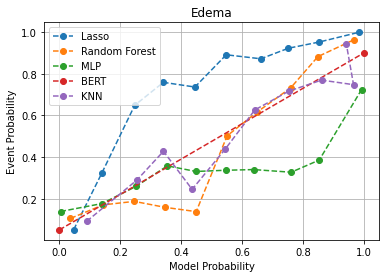

In [39]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/BMC_logreg_tfidf_edema_report_fops.npy')
y=np.load('numpys/BMC_logreg_tfidf_edema_report_mpvs.npy',allow_pickle=True)

m=np.load('numpys/BMC_rf_tfidf_edema_report_fops.npy')
n=np.load('numpys/BMC_rf_tfidf_edema_report_mpvs.npy')

p=np.load('numpys/BMC_nn_tfidf_edema_report_fops.npy')
q=np.load('numpys/BMC_nn_tfidf_edema_report_mpvs.npy')

i=np.load('numpys/BMC_knn_tfidf_edema_report_fops.npy',allow_pickle=True)
j=np.load('numpys/BMC_knn_tfidf_edema_report_mpvs.npy',allow_pickle=True)

a=np.load('uno_numpys/BMC_edema_BERT_fops.npy',allow_pickle=True)[0]
b=np.load('uno_numpys/BMC_edema_BERT_mpvs.npy',allow_pickle=True)[0]


minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(m,axis=0)
n=np.mean(n,axis=0)

p=np.mean(p,axis=0)
q=np.mean(q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.plot(q,p,'o--',label='MLP')
ax.plot(b,a,'o--',label='BERT')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('Edema')

plt.savefig('cal_BMC_edema_tfidf.png')

array([9.24910147e-04, 7.74839049e-01, 8.56932066e-01, 9.99614704e-01])

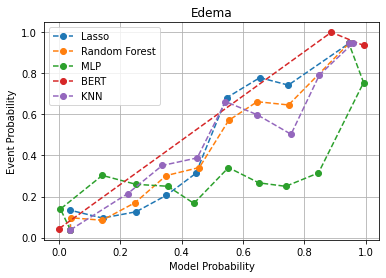

In [125]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/MGBNonLarge_logreg_count_edema_report_fops.npy',allow_pickle=True)
y=np.load('numpys/MGBNonLarge_logreg_count_edema_report_mpvs.npy',allow_pickle=True)

m=np.load('numpys/MGBNonLarge_rf_count_edema_report_fops.npy',allow_pickle=True)
n=np.load('numpys/MGBNonLarge_rf_count_edema_report_mpvs.npy',allow_pickle=True)

p=np.load('numpys/MGBNonLarge_nn_count_edema_report_fops.npy',allow_pickle=True)
q=np.load('numpys/MGBNonLarge_nn_count_edema_report_mpvs.npy',allow_pickle=True)


a=np.load('uno_numpys/BWH_nonLarge_edema_BERT_fops.npy',allow_pickle=True)[6]
b=np.load('uno_numpys/BWH_nonLarge_edema_BERT_mpvs.npy',allow_pickle=True)[6]

minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/MGBNonLarge_knn_count_edema_report_fops.npy',allow_pickle=True)
j=np.load('numpys/MGBNonLarge_knn_count_edema_report_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

reformatted_x=[np.concatenate((begin,k[:minimum],end)) for k in x]
reformatted_y=[np.concatenate((begin,k[:minimum],end)) for k in y]

reformatted_m=[np.concatenate((begin,k[:minimum],end)) for k in m]
reformatted_n=[np.concatenate((begin,k[:minimum],end)) for k in n]

x=np.mean(reformatted_x,axis=0)
y=np.mean(reformatted_y,axis=0)

m=np.mean(reformatted_m,axis=0)
n=np.mean(reformatted_n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.plot(b,a,'o--',label='BERT')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend(loc='upper left')
plt.title('Edema')
plt.savefig('cal_MGBNonLarge_edema_report_count.png')

In [100]:
np.random.normal(0,1,1)

array([-1.30191943])

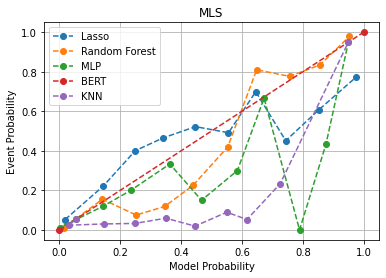

In [40]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/BMC_logreg_count_MLS_presence_fops.npy',allow_pickle=True)
y=np.load('numpys/BMC_logreg_count_MLS_presence_mpvs.npy',allow_pickle=True)

m=np.load('numpys/BMC_rf_count_MLS_presence_fops.npy',allow_pickle=True)
n=np.load('numpys/BMC_rf_count_MLS_presence_mpvs.npy',allow_pickle=True)

p=np.load('numpys/BMC_nn_count_MLS_presence_fops.npy',allow_pickle=True)
q=np.load('numpys/BMC_nn_count_MLS_presence_mpvs.npy',allow_pickle=True)

a=np.load('uno_numpys/BMC_MLS_BERT_fops.npy',allow_pickle=True)[9]
b=np.load('uno_numpys/BMC_MLS_BERT_mpvs.npy',allow_pickle=True)[9]

minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/BMC_knn_count_MLS_presence_fops.npy',allow_pickle=True)
j=np.load('numpys/BMC_knn_count_MLS_presence_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(m,axis=0)
n=np.mean(n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.plot(b,a,'o--',label='BERT')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('MLS')
plt.savefig('cal_bmc_MLS_presence_count.png')

In [28]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/BMC_logreg_tfidf_MLS_presence_fops.npy',allow_pickle=True)
y=np.load('numpys/BMC_logreg_tfidf_MLS_presence_mpvs.npy',allow_pickle=True)

m=np.load('numpys/BMC_rf_tfidf_MLS_presence_fops.npy',allow_pickle=True)
n=np.load('numpys/BMC_rf_tfidf_MLS_presence_mpvs.npy',allow_pickle=True)

p=np.load('numpys/BMC_nn_tfidf_MLS_presence_fops.npy',allow_pickle=True)
q=np.load('numpys/BMC_nn_tfidf_MLS_presence_mpvs.npy',allow_pickle=True)

minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

reformatted_x=[np.concatenate((begin,k[:minimum],end)) for k in x]
reformatted_y=[np.concatenate((begin,k[:minimum],end)) for k in y]

i=np.load('numpys/BMC_knn_tfidf_MLS_presence_fops.npy',allow_pickle=True)
j=np.load('numpys/BMC_knn_tfidf_MLS_presence_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(m,axis=0)
n=np.mean(n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('Midline Shift: TF-IDF')
plt.savefig('cal_bmc_MLS_presence_tfidf.png')

ValueError: operands could not be broadcast together with shapes (10,) (9,) 

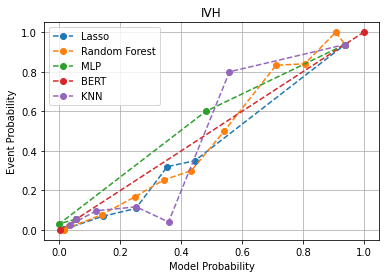

In [162]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/MGB_nonLarge_logreg_count_ivh_present_fops.npy',allow_pickle=True)
y=np.load('numpys/MGB_nonLarge_logreg_count_ivh_present_mpvs.npy',allow_pickle=True)

m=np.load('numpys/MGB_nonLarge_rf_count_ivh_present_fops.npy',allow_pickle=True)
n=np.load('numpys/MGB_nonLarge_rf_count_ivh_present_mpvs.npy',allow_pickle=True)

minimum=min([len(n[k]) for k in range(len(n))])
reformatted_m=[np.concatenate((begin,k[:minimum],end)) for k in m]
reformatted_n=[np.concatenate((begin,k[:minimum],end)) for k in n]

p=np.load('numpys/MGB_nonLarge_nn_count_ivh_present_fops.npy',allow_pickle=True)
q=np.load('numpys/MGB_nonLarge_nn_count_ivh_present_mpvs.npy',allow_pickle=True)


a=np.load('uno_numpys/BWH_NonLarge_IVH_BERT_fops.npy',allow_pickle=True)[9]
b=np.load('uno_numpys/BWH_NonLarge_IVH_BERT_mpvs.npy',allow_pickle=True)[9]


minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/MGB_nonLarge_knn_count_ivh_present_fops.npy',allow_pickle=True)
j=np.load('numpys/MGB_nonLarge_knn_count_ivh_present_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

reformatted_x=[np.concatenate((begin,k[:minimum],end)) for k in x]
reformatted_y=[np.concatenate((begin,k[:minimum],end)) for k in y]


x=np.mean(reformatted_x,axis=0)
y=np.mean(reformatted_y,axis=0)

m=np.mean(reformatted_m,axis=0)
n=np.mean(reformatted_n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)


reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.plot(b,a,'o--',label='BERT')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('IVH')
plt.savefig('cal_MGB_nonLarge_hemcon_count.png')

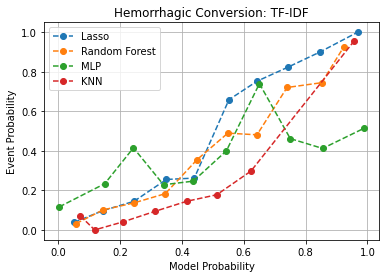

In [130]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_fops.npy',allow_pickle=True)
y=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_mpvs.npy',allow_pickle=True)

m=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_fops.npy',allow_pickle=True)
n=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_mpvs.npy',allow_pickle=True)

p=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_fops.npy',allow_pickle=True)
q=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_mpvs.npy',allow_pickle=True)

# minimum=min([len(q[k]) for k in range(len(q))])
# reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
# reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_fops.npy',allow_pickle=True)
j=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(m,axis=0)
n=np.mean(n,axis=0)
 
p=np.mean(p,axis=0)
q=np.mean(q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('Hemorrhagic Conversion: TF-IDF')
plt.savefig('cal_bmc_hemcon_tfidf.png')

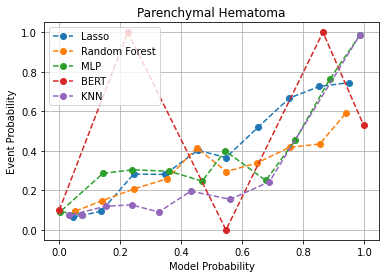

In [67]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/MGBLarge_logreg_count_severe_ecass_fops.npy',allow_pickle=True)
y=np.load('numpys/MGBLarge_logreg_count_severe_ecass_mpvs.npy',allow_pickle=True)

m=np.load('numpys/MGBLarge_rf_count_severe_ecass_fops.npy',allow_pickle=True)
n=np.load('numpys/MGBLarge_rf_count_severe_ecass_mpvs.npy',allow_pickle=True)

p=np.load('numpys/MGBLarge_nn_count_severe_ecass_fops.npy',allow_pickle=True)
q=np.load('numpys/MGBLarge_nn_count_severe_ecass_mpvs.npy',allow_pickle=True)

a=np.load('uno_numpys/BMC_severe_ecass_BERT_fops.npy',allow_pickle=True)[3]
b=np.load('uno_numpys/BMC_severe_ecass_BERT_mpvs.npy',allow_pickle=True)[3]

minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/MGBLarge_knn_count_severe_ecass_fops.npy',allow_pickle=True)
j=np.load('numpys/MGBLarge_knn_count_severe_ecass_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(m,axis=0)
n=np.mean(n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.plot(b,a,'o--',label='BERT')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend(loc='upper left')
plt.title('Parenchymal Hematoma')
plt.savefig('cal_bmc_ecass_count.png')

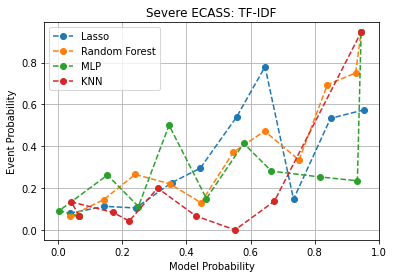

In [126]:
begin=np.random.normal(0.05,0.02,1)
end=np.random.normal(0.95,0.02,1)

x=np.load('numpys/BMC_logreg_tfidf_severe_ecass_fops.npy',allow_pickle=True)
y=np.load('numpys/BMC_logreg_tfidf_severe_ecass_mpvs.npy',allow_pickle=True)

m=np.load('numpys/BMC_rf_tfidf_severe_ecass_fops.npy',allow_pickle=True)
n=np.load('numpys/BMC_rf_tfidf_severe_ecass_mpvs.npy',allow_pickle=True)

minimum=min([len(n[k]) for k in range(len(n))])
reformatted_m=[np.concatenate((begin,k[:minimum],end)) for k in m]
reformatted_n=[np.concatenate((begin,k[:minimum],end)) for k in n]


p=np.load('numpys/BMC_nn_tfidf_severe_ecass_fops.npy',allow_pickle=True)
q=np.load('numpys/BMC_nn_tfidf_severe_ecass_mpvs.npy',allow_pickle=True)

minimum=min([len(q[k]) for k in range(len(q))])
reformatted_p=[np.concatenate((begin,k[:minimum],end)) for k in p]
reformatted_q=[np.concatenate((begin,k[:minimum],end)) for k in q]

i=np.load('numpys/BMC_knn_tfidf_severe_ecass_fops.npy',allow_pickle=True)
j=np.load('numpys/BMC_knn_tfidf_severe_ecass_mpvs.npy',allow_pickle=True)

minimum=min([len(i[k]) for k in range(len(i))])
reformatted_i=[np.concatenate((begin,k[:minimum],end)) for k in i]
reformatted_j=[np.concatenate((begin,k[:minimum],end)) for k in j]

x=np.mean(x,axis=0)
y=np.mean(y,axis=0)

m=np.mean(reformatted_m,axis=0)
n=np.mean(reformatted_n,axis=0)
 
p=np.mean(reformatted_p,axis=0)
q=np.mean(reformatted_q,axis=0)

reformatted_i=np.mean(reformatted_i,axis=0)
reformatted_j=np.mean(reformatted_j,axis=0)

fig,ax=plt.subplots()
ax.plot(y,x,'o--',label='Lasso')
ax.plot(n,m,'o--',label='Random Forest')
ax.plot(q,p,'o--',label='MLP')
ax.set_xlabel('Model Probability')
ax.set_ylabel('Event Probability')
ax.grid(True)
#ax.plot(x_axis,interpolated_i)
ax.plot(reformatted_j,reformatted_i,'o--',label='KNN')
plt.legend()
plt.title('Severe ECASS: TF-IDF')
plt.savefig('cal_bmc_ecass_tfidf.png')

In [42]:
x=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
y=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)


In [5]:
def plot_multiple_rocs(lasso_fprs,lasso_tprs,title):
    mean_fpr = np.linspace(0, 1, 100)

    
    #Lasso: 
    
    #ROC arrays
    lasso_fprs = np.array(lasso_fprs)
    lasso_tprs = np.array(lasso_tprs)

    lasso_interp_tprs = np.array([np.interp(mean_fpr,lasso_fprs[i],lasso_tprs[i]) for i in range(lasso_tprs.shape[0])])


    #standard dev of interpolated TPRs
    lasso_std_interp_tprs = np.std(lasso_interp_tprs,axis=0)

    #establish a mean TPR
    lasso_mean_tpr = np.mean(lasso_interp_tprs, axis=0)

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    lasso_tprs_upper = lasso_mean_tpr + lasso_std_interp_tprs
    lasso_tprs_lower = lasso_mean_tpr - lasso_std_interp_tprs

    #

    for i in lasso_interp_tprs:
        i[0]=0
    
        #plotting!
    fig,ax = plt.subplots()
    #plot red line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
            label='Chance', alpha=0.1)
#     for i in range(2): #hard coded...need to change!
#         ax.plot(mean_fpr,lasso_interp_tprs[i],alpha=0.5)
#         ax.plot(mean_fpr,rf_interp_tprs[i],alpha=0.5)

#     ax.plot(mean_fpr,lasso_mean_tpr,'g--',alpha=0.5)
#     ax.plot(mean_fpr,rf_mean_tpr,'b--',alpha=0.5)
    ax.fill_between(mean_fpr, lasso_tprs_lower, lasso_tprs_upper, color='red',alpha=0.8,
                   label=r'Lasso ($\pm$ 1 std. dev.)')
    
    plt.title(title)
    ax.legend(False)
    plt.grid(True,alpha=0.2)
    #plt.savefig("bwh_severeEcass_prediction.png")
    plt.show()

### Plot ROC Curves

In [5]:
def plot_multiple_roc_4(bert_fprs,bert_tprs,lasso_fprs,lasso_tprs,rf_fprs,rf_tprs,mlp_fprs,mlp_tprs,knn_fprs,knn_tprs,title,save_name):
    mean_fpr = np.linspace(0, 1, 100)

    #BERT:
       
    bert_fprs = np.array(bert_fprs)
    bert_tprs = np.array(bert_tprs)

    bert_interp_tprs = np.array([np.interp(mean_fpr,bert_fprs[i],bert_tprs[i]) for i in range(bert_tprs.shape[0])])


    #standard dev of interpolated TPRs
    bert_std_interp_tprs = np.std(bert_interp_tprs,axis=0)

    #establish a mean TPR
    bert_mean_tpr = np.mean(bert_interp_tprs, axis=0)
    bert_mean_tpr[0]=0

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    bert_tprs_upper = bert_mean_tpr + bert_std_interp_tprs
    bert_tprs_lower = bert_mean_tpr - bert_std_interp_tprs

    #

    for i in bert_interp_tprs:
        i[0]=0
    
    
    #Lasso: 
    
    #ROC arrays
    lasso_fprs = np.array(lasso_fprs)
    lasso_tprs = np.array(lasso_tprs)

    lasso_interp_tprs = np.array([np.interp(mean_fpr,lasso_fprs[i],lasso_tprs[i]) for i in range(lasso_tprs.shape[0])])


    #standard dev of interpolated TPRs
    lasso_std_interp_tprs = np.std(lasso_interp_tprs,axis=0)

    #establish a mean TPR
    lasso_mean_tpr = np.mean(lasso_interp_tprs, axis=0)
    lasso_mean_tpr[0]=0

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    lasso_tprs_upper = lasso_mean_tpr + lasso_std_interp_tprs
    lasso_tprs_lower = lasso_mean_tpr - lasso_std_interp_tprs

    #

    for i in lasso_interp_tprs:
        i[0]=0
    
    
    #Random_Forest
    rf_fprs = np.array(rf_fprs)
    rf_tprs = np.array(rf_tprs)

    rf_interp_tprs = np.array([np.interp(mean_fpr,rf_fprs[i],rf_tprs[i]) for i in range(rf_tprs.shape[0])])


    #standard dev of interpolated TPRs
    rf_std_interp_tprs = np.std(rf_interp_tprs,axis=0)

    #establish a mean TPR
    rf_mean_tpr = np.mean(rf_interp_tprs, axis=0)
    rf_mean_tpr[0]=0

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    rf_tprs_upper = rf_mean_tpr + rf_std_interp_tprs
    rf_tprs_lower = rf_mean_tpr - rf_std_interp_tprs

    #

    for i in rf_interp_tprs:
        i[0]=0
        
        
        
    #mlp: 
    
    #ROC arrays
    mlp_fprs = np.array(mlp_fprs)
    mlp_tprs = np.array(mlp_tprs)

    mlp_interp_tprs = np.array([np.interp(mean_fpr,mlp_fprs[i],mlp_tprs[i]) for i in range(mlp_tprs.shape[0])])
    


    #standard dev of interpolated TPRs
    mlp_std_interp_tprs = np.std(mlp_interp_tprs,axis=0)

    #establish a mean TPR
    mlp_mean_tpr = np.mean(mlp_interp_tprs, axis=0)
    mlp_mean_tpr[0]=0

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    mlp_tprs_upper = mlp_mean_tpr + mlp_std_interp_tprs
    mlp_tprs_lower = mlp_mean_tpr - mlp_std_interp_tprs

    #

    for i in mlp_interp_tprs:
        i[0]=0
        
    ##KNN

    
    knn_fprs = np.array(knn_fprs)
    knn_tprs = np.array(knn_tprs)

    knn_interp_tprs = np.array([np.interp(mean_fpr,knn_fprs[i],knn_tprs[i]) for i in range(knn_tprs.shape[0])])


    #standard dev of interpolated TPRs
    knn_std_interp_tprs = np.std(knn_interp_tprs,axis=0)

    #establish a mean TPR
    knn_mean_tpr = np.mean(knn_interp_tprs, axis=0)

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    knn_tprs_upper = knn_mean_tpr + knn_std_interp_tprs
    knn_tprs_lower = knn_mean_tpr - knn_std_interp_tprs

    #

    for i in knn_interp_tprs:
        i[0]=0
        
    
        
    #plotting!
    fig,ax = plt.subplots()
    #plot red line
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
            label='Chance', alpha=0.8)
#     for i in range(2): #hard coded...need to change!
#         ax.plot(mean_fpr,lasso_interp_tprs[i],alpha=0.5)
#         ax.plot(mean_fpr,rf_interp_tprs[i],alpha=0.5)

#     ax.plot(mean_fpr,lasso_mean_tpr,'g--',alpha=0.5)
#     ax.plot(mean_fpr,rf_mean_tpr,'b--',alpha=0.5)
#     ax.fill_between(mean_fpr, lasso_tprs_lower, lasso_tprs_upper, color='red',alpha=0.8,
#                    label=r'Lasso ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, rf_tprs_lower, rf_tprs_upper, color='blue',alpha=0.8,
#                    label=r'RandomForest ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, mlp_tprs_lower, mlp_tprs_upper, color='green',alpha=0.8,
#                     label=r'MLP ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, knn_tprs_lower, knn_tprs_upper, color='cyan',alpha=0.8,
#                     label=r'K-NN ($\pm$ 1 std. dev.)')
    
    ax.plot(mean_fpr,bert_mean_tpr,'m-',label=r'BioClinical BERT')
    
    ax.plot(mean_fpr, lasso_mean_tpr, 'g-',
                    label=r'Lasso ')
    
    ax.plot(mean_fpr, rf_mean_tpr, 'r-',
                    label=r'Random Forest ')
    
    ax.plot(mean_fpr, mlp_mean_tpr, 'b-',
                    label=r'MLP ')
    
    ax.plot(mean_fpr, knn_mean_tpr, 'c-',
                    label=r'K-NN ')
    
    plt.title(title)
   # plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    #ax.legend(False)
    plt.grid(True,alpha=0.2)
    plt.savefig('figures/roc_'+save_name+'.png')
    plt.show()

## Plot Multiple PR Curves

In [1]:
def plot_multiple_PR_4(bert_fprs,bert_tprs,lasso_fprs,lasso_tprs,rf_fprs,rf_tprs,mlp_fprs,mlp_tprs,knn_fprs,knn_tprs,title,save_name):
    mean_fpr = np.linspace(0, 1, 100)

    
    
    #BERT:


    
    #bert: 
    
    #ROC arrays
    bert_fprs = np.array(bert_fprs)
    bert_tprs = np.array(bert_tprs)

    bert_interp_tprs = np.array([np.interp(mean_fpr,bert_fprs[i],bert_tprs[i]) for i in range(bert_tprs.shape[0])])


    #standard dev of interpolated TPRs
    bert_std_interp_tprs = np.std(bert_interp_tprs,axis=0)

    #establish a mean TPR
    bert_mean_tpr = np.mean(bert_interp_tprs, axis=0)
    #bert_mean_tpr[0]=1

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    bert_tprs_upper = bert_mean_tpr + bert_std_interp_tprs
    bert_tprs_lower = bert_mean_tpr - bert_std_interp_tprs

    #

    for i in bert_interp_tprs:
        i[0]=0
    
    
    #Lasso: 
    
    #ROC arrays
    lasso_fprs = np.array(lasso_fprs)
    lasso_tprs = np.array(lasso_tprs)

    lasso_interp_tprs = np.array([np.interp(mean_fpr,lasso_fprs[i],lasso_tprs[i]) for i in range(lasso_tprs.shape[0])])


    #standard dev of interpolated TPRs
    lasso_std_interp_tprs = np.std(lasso_interp_tprs,axis=0)

    #establish a mean TPR
    lasso_mean_tpr = np.mean(lasso_interp_tprs, axis=0)
    #lasso_mean_tpr[0]=1

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    lasso_tprs_upper = lasso_mean_tpr + lasso_std_interp_tprs
    lasso_tprs_lower = lasso_mean_tpr - lasso_std_interp_tprs

    #

    for i in lasso_interp_tprs:
        i[0]=0
    
    
    #Random_Forest
    rf_fprs = np.array(rf_fprs)
    rf_tprs = np.array(rf_tprs)

    rf_interp_tprs = np.array([np.interp(mean_fpr,rf_fprs[i],rf_tprs[i]) for i in range(rf_tprs.shape[0])])


    #standard dev of interpolated TPRs
    rf_std_interp_tprs = np.std(rf_interp_tprs,axis=0)

    #establish a mean TPR
    rf_mean_tpr = np.mean(rf_interp_tprs, axis=0)
    #rf_mean_tpr[0]=1

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    rf_tprs_upper = rf_mean_tpr + rf_std_interp_tprs
    rf_tprs_lower = rf_mean_tpr - rf_std_interp_tprs

    #

    for i in rf_interp_tprs:
        i[0]=0
        
        
        
    #mlp: 
    
    #ROC arrays
    mlp_fprs = np.array(mlp_fprs)
    mlp_tprs = np.array(mlp_tprs)

    mlp_interp_tprs = np.array([np.interp(mean_fpr,mlp_fprs[i],mlp_tprs[i]) for i in range(mlp_tprs.shape[0])])
    


    #standard dev of interpolated TPRs
    mlp_std_interp_tprs = np.std(mlp_interp_tprs,axis=0)

    #establish a mean TPR
    mlp_mean_tpr = np.mean(mlp_interp_tprs, axis=0)
    #mlp_mean_tpr[0]=1

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    mlp_tprs_upper = mlp_mean_tpr + mlp_std_interp_tprs
    mlp_tprs_lower = mlp_mean_tpr - mlp_std_interp_tprs

    #

    for i in mlp_interp_tprs:
        i[0]=0
        
    ##KNN

    
    knn_fprs = np.array(knn_fprs)
    knn_tprs = np.array(knn_tprs)

    knn_interp_tprs = np.array([np.interp(mean_fpr,knn_fprs[i],knn_tprs[i]) for i in range(knn_tprs.shape[0])])


    #standard dev of interpolated TPRs
    knn_std_interp_tprs = np.std(knn_interp_tprs,axis=0)

    #establish a mean TPR
    knn_mean_tpr = np.mean(knn_interp_tprs, axis=0)
    #knn_mean_tpr[0]=1

    #mean_tpr[-1] = 1.0

    #upper and lower bounds for interp_TPRs
    knn_tprs_upper = knn_mean_tpr + knn_std_interp_tprs
    knn_tprs_lower = knn_mean_tpr - knn_std_interp_tprs

    #

    for i in knn_interp_tprs:
        i[0]=0
        
    
        
    #plotting!
    fig,ax = plt.subplots()
    #plot red line

#     for i in range(2): #hard coded...need to change!
#         ax.plot(mean_fpr,lasso_interp_tprs[i],alpha=0.5)
#         ax.plot(mean_fpr,rf_interp_tprs[i],alpha=0.5)

#     ax.plot(mean_fpr,lasso_mean_tpr,'g--',alpha=0.5)
#     ax.plot(mean_fpr,rf_mean_tpr,'b--',alpha=0.5)
#     ax.fill_between(mean_fpr, lasso_tprs_lower, lasso_tprs_upper, color='red',alpha=0.8,
#                    label=r'Lasso ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, rf_tprs_lower, rf_tprs_upper, color='blue',alpha=0.8,
#                    label=r'RandomForest ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, mlp_tprs_lower, mlp_tprs_upper, color='green',alpha=0.8,
#                     label=r'MLP ($\pm$ 1 std. dev.)')
    
#     ax.fill_between(mean_fpr, knn_tprs_lower, knn_tprs_upper, color='cyan',alpha=0.8,
#                     label=r'K-NN ($\pm$ 1 std. dev.)')
    ax.plot(mean_fpr,bert_mean_tpr,'m-',label=r'BERT')
    
    
    ax.plot(mean_fpr, lasso_mean_tpr, 'g-',
                    label=r'Lasso ')
    
    ax.plot(mean_fpr, rf_mean_tpr, 'r-',
                    label=r'Random Forest ')
    
    ax.plot(mean_fpr, mlp_mean_tpr, 'b-',
                    label=r'MLP ')
    
    ax.plot(mean_fpr, knn_mean_tpr, 'c-',
                    label=r'K-NN ')
    
    #plt.title(title)
    #ax.get_legend().remove()
    #plt.xlabel('Recall')
    #plt.ylabel('Precision')
    plt.grid(True,alpha=0.2)
    plt.savefig('figures/pr_'+save_name+'.png')
    plt.show()

# Large MGB Stroke

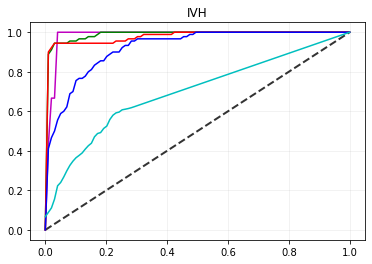

In [11]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_IVH_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_IVH_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'IVH','mgb_edema_tfidf')

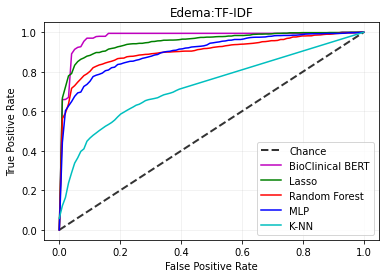

In [9]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_edema_report_tprs.npy',al low_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','mgb_edema_tfidf')

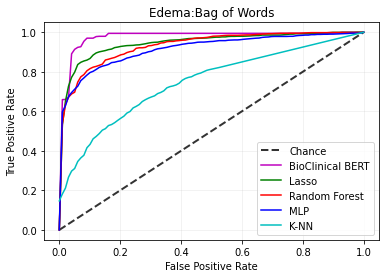

In [10]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:Bag of Words','mgb_edema_bow')

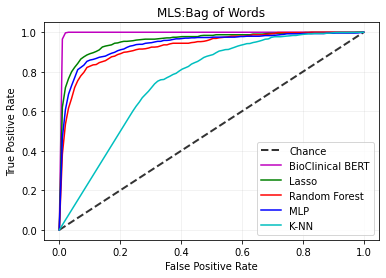

In [11]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS:Bag of Words','mgb_edema_bow')

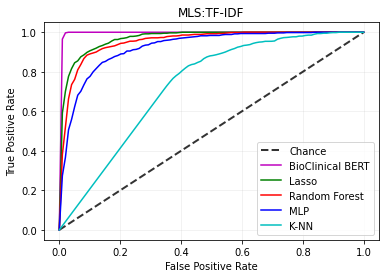

In [12]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS:TF-IDF','mgb_MLS_tfidf')

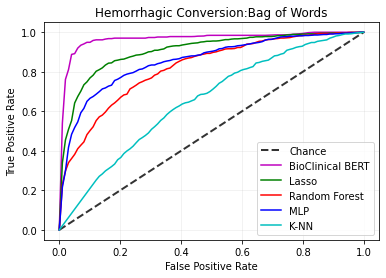

In [13]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:Bag of Words','mgb_hemcon_bow')

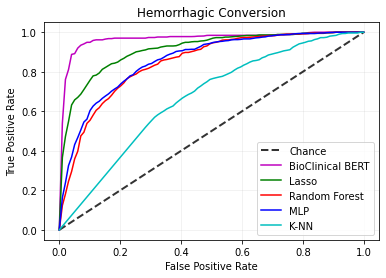

In [63]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion','FINAL_MGBLarge_hemcon_tfidf')

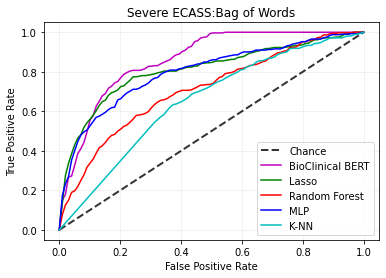

In [15]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:Bag of Words','mgb_ECASS_bow')

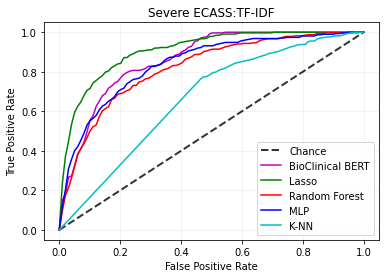

In [16]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:TF-IDF','mgb_ECASS_tfidf')

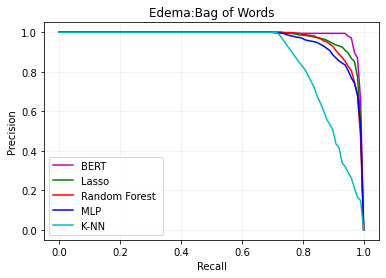

In [17]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:Bag of Words','mgb_edema_count')

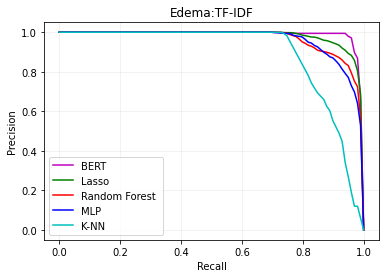

In [18]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','mgb_edema_tfidf')

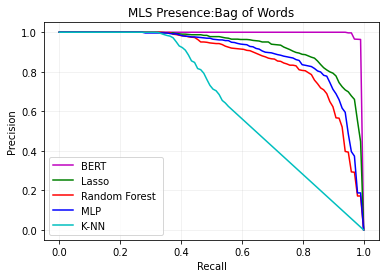

In [19]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS Presence:Bag of Words','mgb_MLS_count')

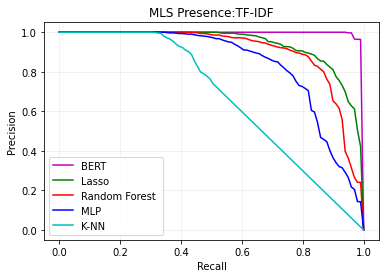

In [20]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS Presence:TF-IDF','mgb_MLS_tfidf')

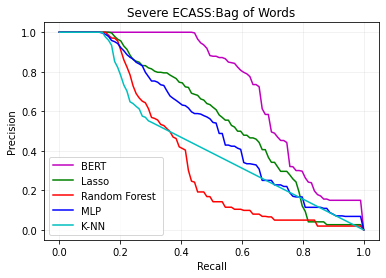

In [21]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:Bag of Words','mgb_ECASS_count')

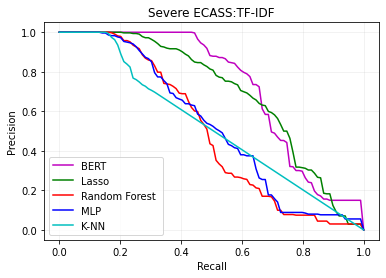

In [23]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:TF-IDF','mgb_ECASS_tfidf')

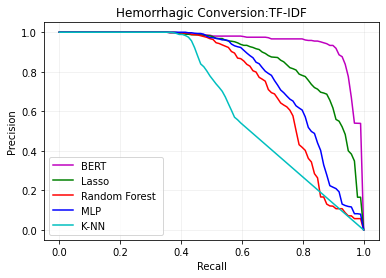

In [24]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:TF-IDF','mgb_hemcon_tfidf')

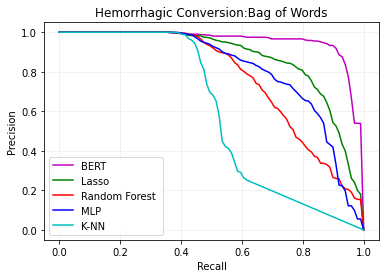

In [25]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:Bag of Words','mgb_hemcon_bow')

In [14]:
lr_prec=np.load('numpys/MGBLarge_logreg_count_edema_report_precisions.npy',allow_pickle=True)
lr_rec=np.load('numpys/MGBLarge_logreg_count_edema_report_recalls.npy',allow_pickle=True)

tfidf_prec=np.load('numpys/MGBLarge_knn_tfidf_edema_report_precisions.npy',allow_pickle=True)
tfidf_rec=np.load('numpys/MGBLarge_knn_tfidf_edema_report_recalls.npy',allow_pickle=True)

# BMC

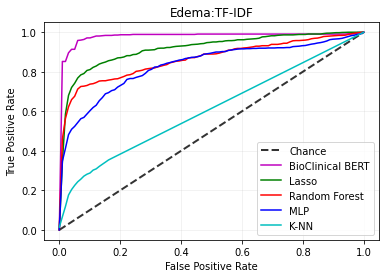

In [26]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','bmc_edema_tfidf')

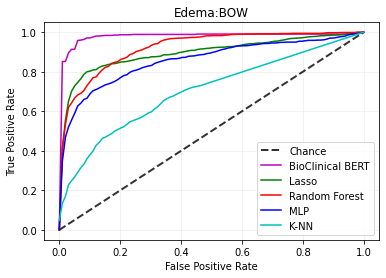

In [27]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:BOW','bmc_edema_bow')

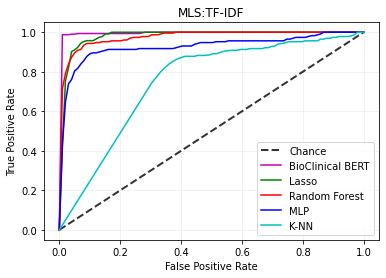

In [28]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS:TF-IDF','bmc_mls_tfidf')

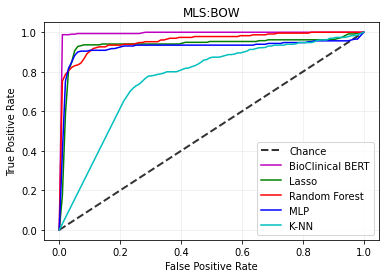

In [29]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS:BOW','bmc_MLS_count')

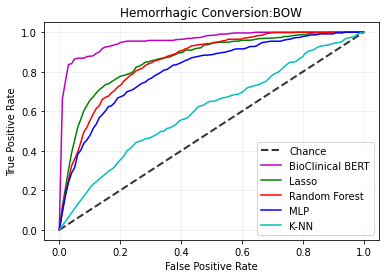

In [30]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:BOW','bmc_hemcon_count')

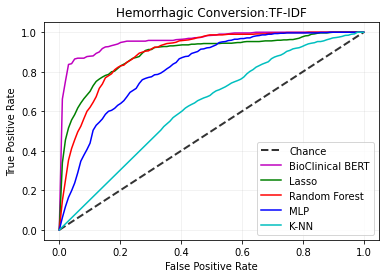

In [31]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:TF-IDF','bmc_hemcon_tfidf')

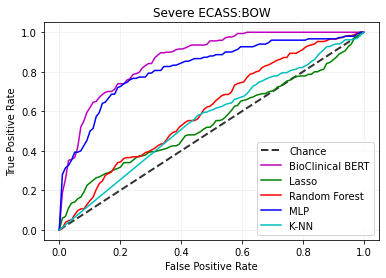

In [32]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:BOW','bmc_ecass_count')

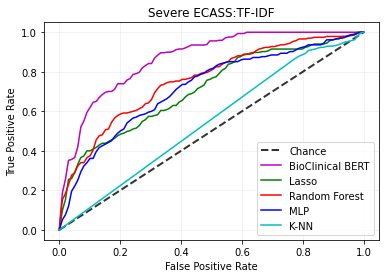

In [33]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:TF-IDF','bmc_ecass_tfidf')

## PR Curves

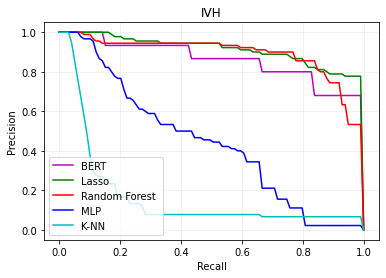

In [146]:
bert_fpr=np.load('uno_numpys/BMC_IVH_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_IVH_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'IVH','MGB_nonLarge_edema_tfidf')

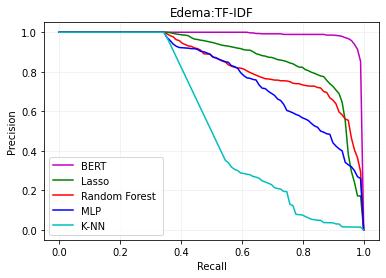

In [34]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','bmc_edema_tfidf')

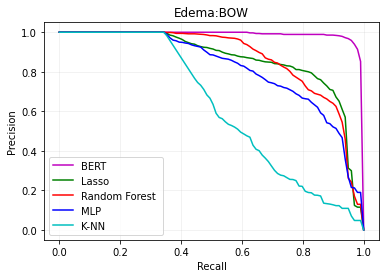

In [35]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:BOW','bmc_edema_bow')

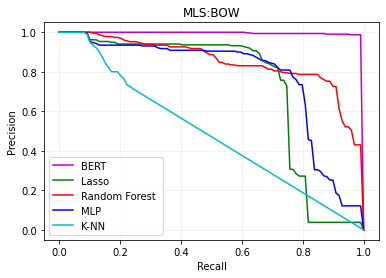

In [36]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS:BOW','bmc_MLS_count')

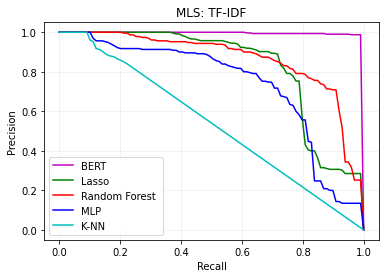

In [37]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS: TF-IDF','bmc_MLS_tfidf')

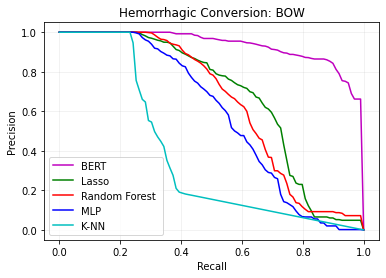

In [38]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion: BOW','bmc_hemcon_bow')

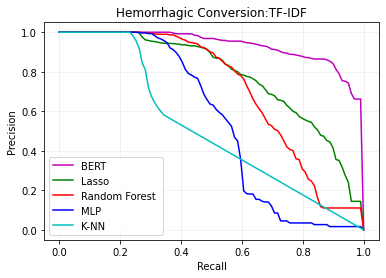

In [39]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:TF-IDF','bmc_hemcon_tfidf')

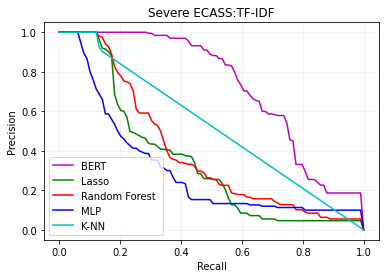

In [40]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:TF-IDF','bmc_ecass_tfidf')

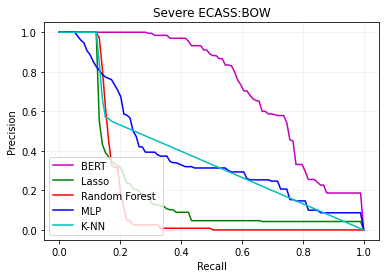

In [41]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Severe ECASS:BOW','bmc_ecass_bow')

## BWH Non-Large

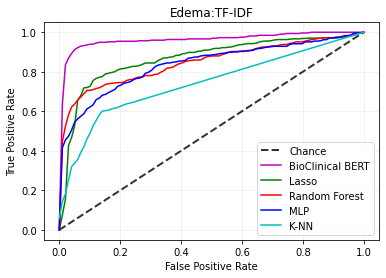

In [42]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','mgb_NonLarge_edema_tfidf')

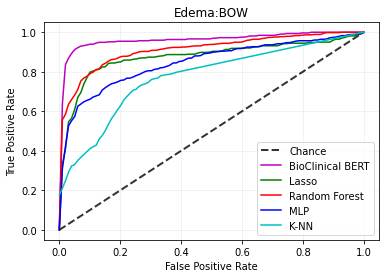

In [43]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:BOW','mgb_NonLarge_edema_count')

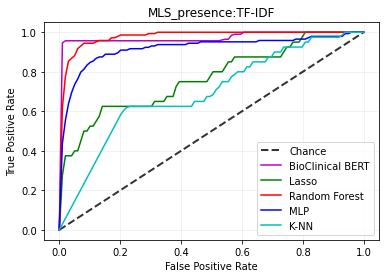

In [46]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS_presence:TF-IDF','mgb_NonLarge_MLS_presence_tfidf')

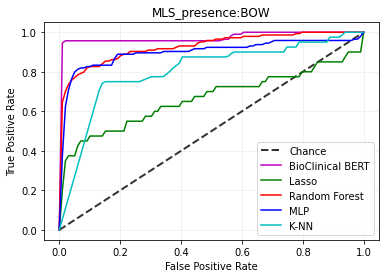

In [47]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS_presence:BOW','mgb_NonLarge_MLS_presence_count')

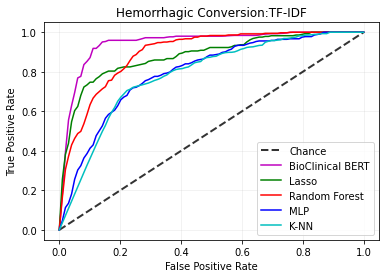

In [49]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:TF-IDF','mgb_NonLarge_hem_conv_v2_tfidf')

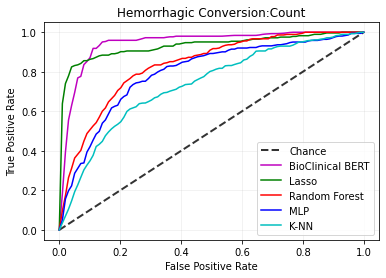

In [50]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:Count','mgb_NonLarge_hem_conv_v2_count')

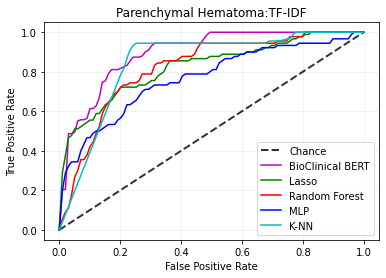

In [51]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma:TF-IDF','mgb_NonLarge_severe_ecass_tfidf')

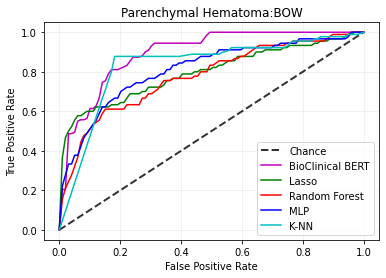

In [52]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma:BOW','mgb_NonLarge_severe_ecass_count')

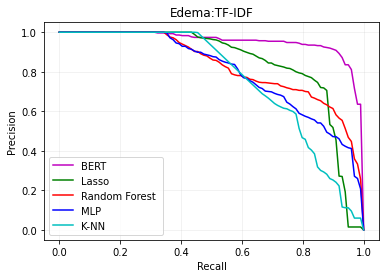

In [53]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:TF-IDF','mgb_NonLarge_edema_tfidf')

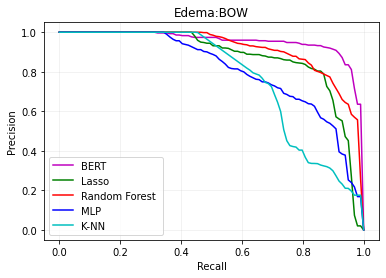

In [54]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema:BOW','mgb_NonLarge_edema_count')

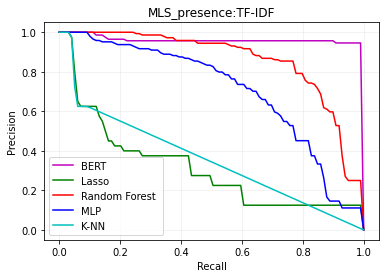

In [55]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS_presence:TF-IDF','mgb_NonLarge_MLS_presence_tfidf')

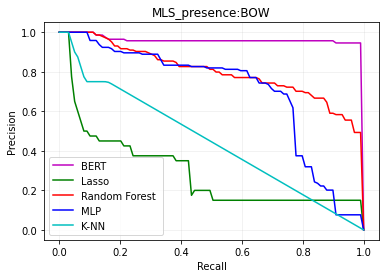

In [56]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS_presence:BOW','mgb_NonLarge_MLS_presence_count')

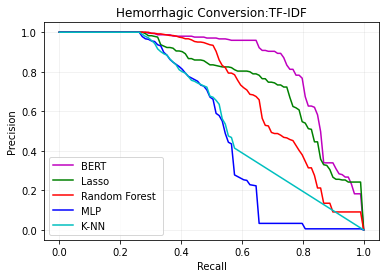

In [57]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:TF-IDF','mgb_NonLarge_hem_conv_v2_tfidf')

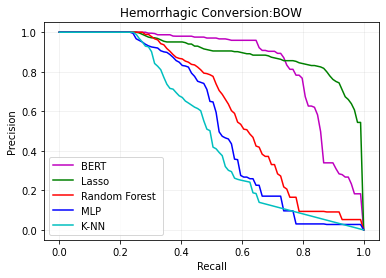

In [58]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion:BOW','mgb_NonLarge_hem_conv_v2_count')

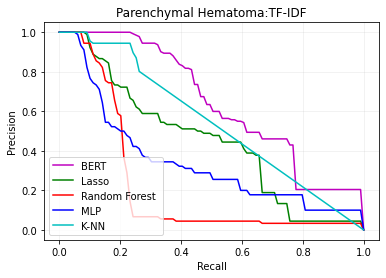

In [59]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma:TF-IDF','mgb_NonLarge_severe_ecass_tfidf')

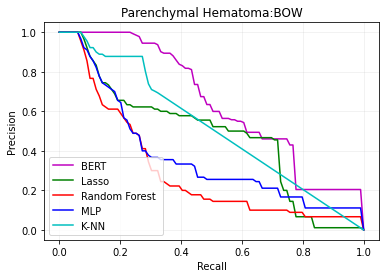

In [60]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_count_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_count_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma:BOW','mgb_NonLarge_severe_ecass_count')

# FINAL FIGURES: ROCs

## 1.a.1: BWH Large Edema

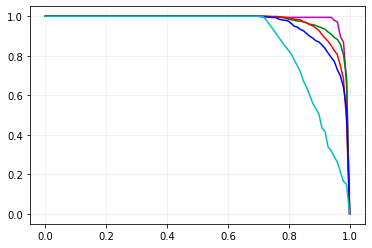

In [14]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema','FINAL_MGBLarge_EDEMA')

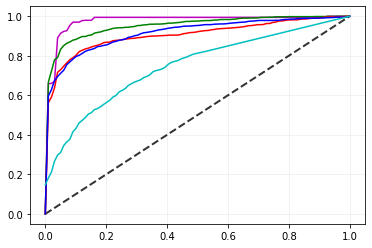

In [30]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_edema_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_edema')

## 1.a.2: BWH Large MLS

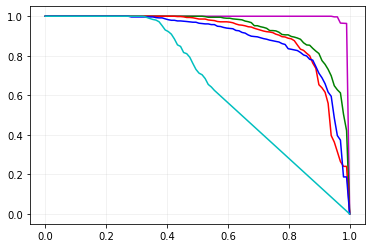

In [15]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS','FINAL_MGBLarge_MLS')

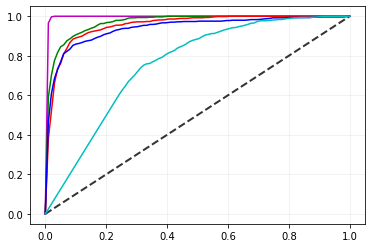

In [31]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_edema')

## 1.a.3: BWH Large HemCon

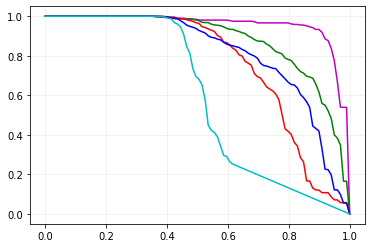

In [16]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion','FINAL_MGBLarge_hemcon')

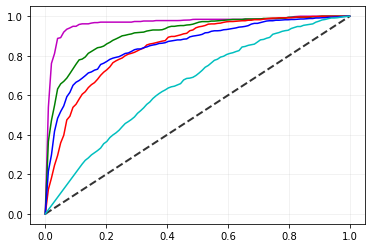

In [32]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_edema')

## 1.a.4: BWH Large Parenchymal Hematoma

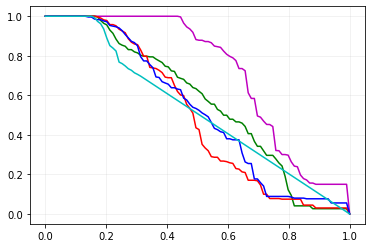

In [17]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma','FINAL_MGBLarge_ECASS')

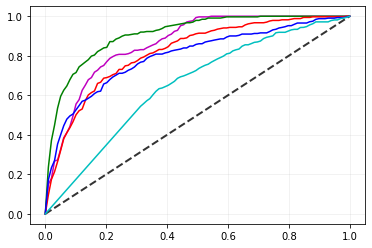

In [33]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_edema')

## 1.a.5 BWH Large IVH Present

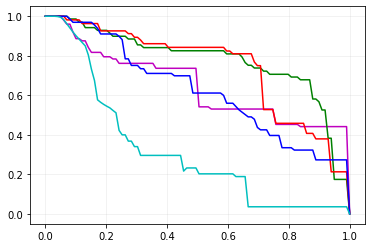

In [7]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_IVH_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_IVH_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_count_ivh_present_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_count_ivh_present_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_ivh_present_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_ivh_present_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma','FINAL_MGBLarge_IVH')

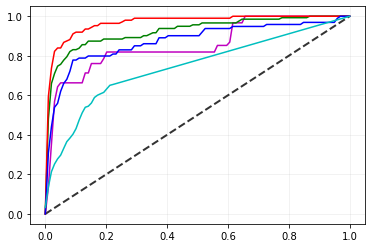

In [34]:
bert_fpr=np.load('uno_numpys/BWH_LARGE_IVH_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_LARGE_IVH_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBLarge_logreg_tfidf_ivh_present_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBLarge_logreg_tfidf_ivh_present_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBLarge_rf_tfidf_ivh_present_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBLarge_rf_tfidf_ivh_present_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBLarge_nn_count_ivh_present_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBLarge_nn_count_ivh_present_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBLarge_knn_count_ivh_present_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBLarge_knn_count_ivh_present_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_edema')

## 1.b.1: BWH Non-Large Edema

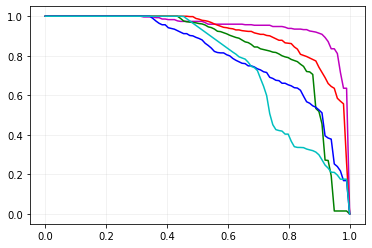

In [22]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema','NL_FINAL_edema')

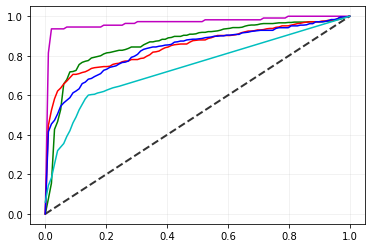

In [18]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_edema_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','mgbnon_edema_tfidf')

## 1.b.2: BWH Non-Large MLS

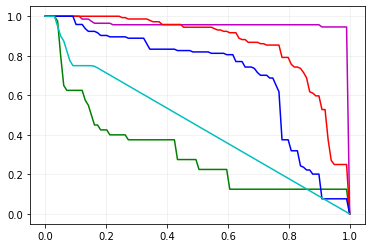

In [23]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'MLS','NL_FINAL_MLS_presence')

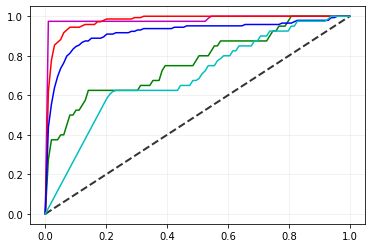

In [17]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_mls_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','mgbnon_MLS_tfidf')

## 1.b.3: BWH Non-Large HemCon

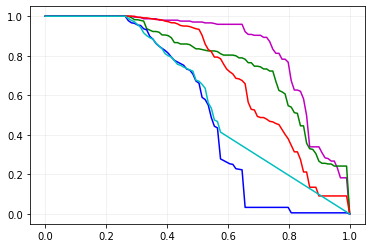

In [24]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion','NL_FINAL_hemcon')

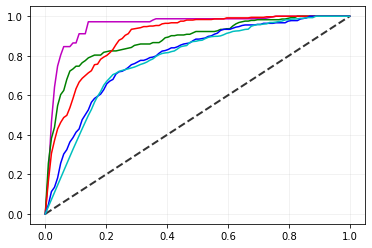

In [16]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_hemcon_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','mgbnon_hemcon_tfidf')

## 1.b.4: BWH Non-Large Parenchymal Hematoma

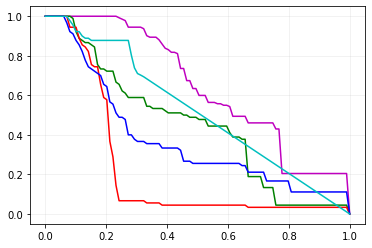

In [25]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_count_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_count_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma','NL_FINAL_severe_ecass')

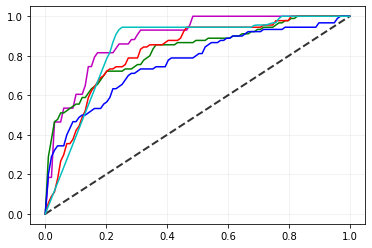

In [15]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_severe_ecass_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGBNonLarge_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGBNonLarge_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGBNonLarge_nn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGBNonLarge_knn_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','mgbnon_ecass_tfidf')

## 1.b.5 BWH non-Large IVH Present

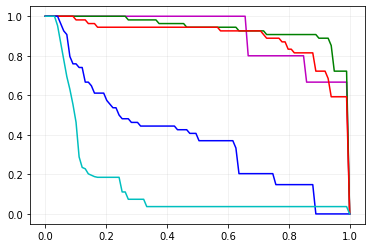

In [6]:
bert_fpr=np.load('uno_numpys/MGB_nonLarge_IVH_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/MGB_nonLarge_IVH_BERT_recalls.npy',allow_pickle=True)



lr_fpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGB_nonLarge_nn_count_ivh_present_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGB_nonLarge_nn_count_ivh_present_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma','FINAL_MGB_nonLarge_IVH')

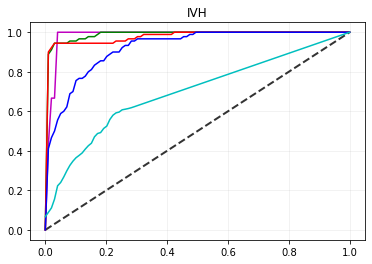

In [12]:
bert_fpr=np.load('uno_numpys/BWH_nonLarge_IVH_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BWH_nonLarge_IVH_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/MGB_nonLarge_logreg_tfidf_ivh_present_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/MGB_nonLarge_rf_tfidf_ivh_present_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/MGB_nonLarge_nn_tfidf_ivh_present_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/MGB_nonLarge_knn_tfidf_ivh_present_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'IVH','mgb_edema_tfidf')

## 1.c.1: BMC Large Edema

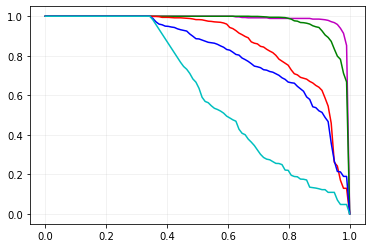

In [18]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_edema_report_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_edema_report_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_edema_report_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_edema_report_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_edema_report_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_edema_report_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_edema_report_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_edema_report_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Edema','FINAL_BMC_edema')

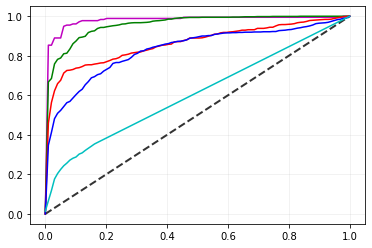

In [19]:
bert_fpr=np.load('uno_numpys/BMC_edema_BERT_fprs.npy',allow_pickle=True)[0:3]
bert_tpr=np.load('uno_numpys/BMC_edema_BERT_tprs.npy',allow_pickle=True)[0:3]

lr_fpr=np.load('numpys/BMC_logreg_tfidf_edema_report_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_edema_report_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_edema_report_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_edema_report_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_edema_report_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_edema_report_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_edema_report_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_edema_report_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','bmc_edema_tfidf')

## 1.c.2: BMC Large MLS

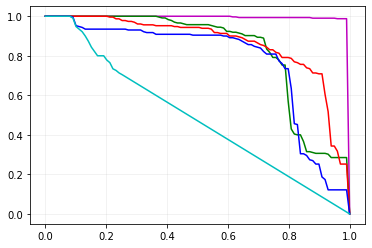

In [25]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_MLS_presence_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_MLS_presence_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_MLS_presence_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_MLS_presence_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_BMC_MLS')

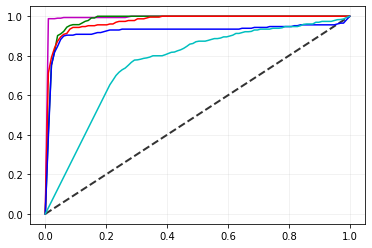

In [26]:
bert_fpr=np.load('uno_numpys/BMC_mls_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_mls_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_MLS_presence_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_MLS_presence_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_MLS_presence_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_MLS_presence_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_MLS_presence_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_BMC_MLS')

## 1.c.3: BMC HemCon

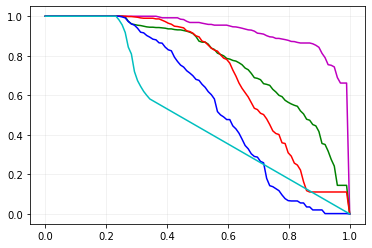

In [20]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_hem_conv_v2_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_hem_conv_v2_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_hem_conv_v2_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Hemorrhagic Conversion','FINAL_BMC_hemcon')

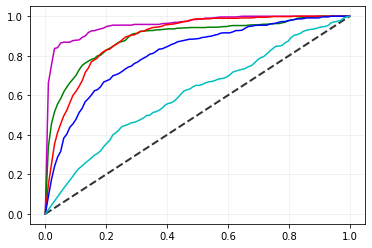

In [27]:
bert_fpr=np.load('uno_numpys/BMC_hemcon_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_hemcon_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_hem_conv_v2_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_hem_conv_v2_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_hem_conv_v2_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_BMC_hemcon')

## 1.c.4: BMC Parenchymal Hematoma

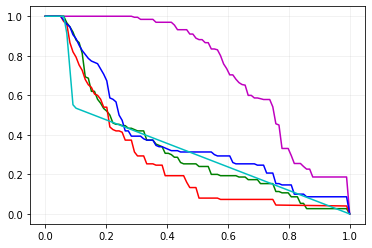

In [21]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_severe_ecass_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_severe_ecass_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_count_severe_ecass_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_count_severe_ecass_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_severe_ecass_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_severe_ecass_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_severe_ecass_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_severe_ecass_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma*','FINAL_BMC_ECASS')

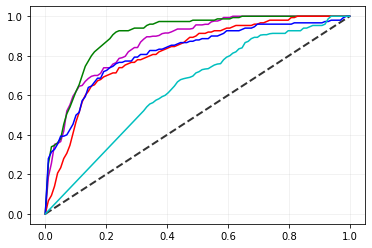

In [28]:
bert_fpr=np.load('uno_numpys/BMC_severe_ecass_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_severe_ecass_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_severe_ecass_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_severe_ecass_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_severe_ecass_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_severe_ecass_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_severe_ecass_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_ecass_hemcon')

## 1.c.5 IVH Present 

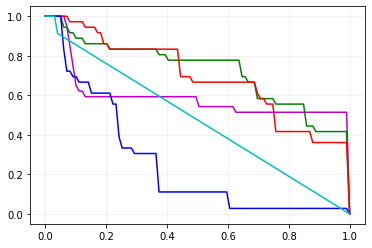

In [6]:
bert_fpr=np.load('uno_numpys/BMC_IVH_BERT_precisions.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_IVH_BERT_recalls.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_count_ivh_present_precisions.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_count_ivh_present_recalls.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_ivh_present_precisions.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_ivh_present_recalls.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_tfidf_ivh_present_precisions.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_tfidf_ivh_present_recalls.npy',allow_pickle=True)

plot_multiple_PR_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'Parenchymal Hematoma','FINAL_BMC_IVH')

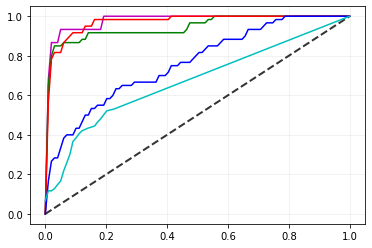

In [29]:
bert_fpr=np.load('uno_numpys/BMC_IVH_BERT_fprs.npy',allow_pickle=True)
bert_tpr=np.load('uno_numpys/BMC_IVH_BERT_tprs.npy',allow_pickle=True)

lr_fpr=np.load('numpys/BMC_logreg_tfidf_ivh_present_fprs.npy',allow_pickle=True)
lr_tpr=np.load('numpys/BMC_logreg_tfidf_ivh_present_tprs.npy',allow_pickle=True)

rf_fpr=np.load('numpys/BMC_rf_tfidf_ivh_present_fprs.npy',allow_pickle=True)
rf_tpr=np.load('numpys/BMC_rf_tfidf_ivh_present_tprs.npy',allow_pickle=True)

nn_fpr=np.load('numpys/BMC_nn_count_ivh_present_fprs.npy',allow_pickle=True)
nn_tpr=np.load('numpys/BMC_nn_count_ivh_present_tprs.npy',allow_pickle=True)

knn_fpr=np.load('numpys/BMC_knn_count_ivh_present_fprs.npy',allow_pickle=True)
knn_tpr=np.load('numpys/BMC_knn_count_ivh_present_tprs.npy',allow_pickle=True)

plot_multiple_roc_4(bert_fpr,bert_tpr,lr_fpr,lr_tpr,rf_fpr,rf_tpr,nn_fpr,nn_tpr,knn_fpr,knn_tpr,'','FINAL_IVH')